## US Election 2020 Twitter Sentiment Analysis

There are plenty of existing population polls trying to predict the outcome of a Presidential election. It would be of interest to perform ML sentiment analysis of a sample of past Twitter feeds (before it became X) to see how accurate it would be. Of course it begs the question if the sample population in Twitter has a diverse representation. On the other hand, the same can be said of the traditional polls and whether their samples are also diverse.

#### Dataset
I am using the [US Election 2020 Sample Dataset](https://www.kaggle.com/datasets/manchunhui/us-election-2020-tweets/data) from Kaggle for this analysis. It consists of two CSV files totaling about 1.7 million rows, one with Tweets focused on Joe Biden, and the other on Donald Trump. The dataset needs to be culled of Tweets originating outside of the US. While that doesn’t guarantee that non-US citizens in the US are Tweeting (or that citizens outside of the US are Tweeting) it helps narrow down any international opinions that would skew the results. The rest would be just data cleaning, for example, removing hashtags/mentions, URLs, and any extraneous text that is not generally readable and that may not convert to useful tokens. However, there some tools exist to help with data cleaning as well.

#### Tools
As of late there are several publicly available LLMs that can assist with sentiment analysis, specifically on Twitter/X data. I'd like to explore the use of Hugging Face's [Twitter roBERTa-base Sentiment Analysis module](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest). Additionally, the [distilBERT](https://huggingface.co/docs/transformers/en/model_doc/distilbert) and [sieBERT](https://huggingface.co/siebert/sentiment-roberta-large-english) models will be compared as well.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import plotly.express as px
import re   # regex for data cleaning
from tqdm import tqdm    # Shows progress bar for long tasks
from google.colab import drive
from sklearn.metrics import cohen_kappa_score

---
## Analyzing results from multiple sentiment models

I have run the election dataset through the three sentiment analysis models above: roBERTa, distilBERT, and sieBERT, and save each output DF to a CSV so we don't have to keep rerunning the models.

#### Reading in results


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Read in various model results
roberta_df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/results/tweetUSA_sentiment_roBERTa.csv",
    lineterminator='\n',
    header=0,
    index_col=0,
    dtype={"city": str, "state": str, "state_code": str},
    low_memory=False
)

distilbert_df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/results/tweetUSA_sentiment_distilBERT.csv",
    lineterminator='\n',
    header=0,
    index_col=0,
    dtype={"city": str, "state": str, "state_code": str},
    low_memory=False
)

sieb_df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/results/tweetUSA_sentiment_siebert.csv",
    lineterminator='\n',
    header=0,
    index_col=0,
    dtype={"city": str, "state": str, "state_code": str},
    low_memory=False
)

Cleaning up the data a little and make sure data formats match.

In [4]:
roberta_df.columns = roberta_df.columns.str.strip()
distilbert_df.columns = distilbert_df.columns.str.strip()
sieb_df.columns = sieb_df.columns.str.strip()

In [5]:
roberta_df['sentiment']= roberta_df['sentiment'].str.lower()
distilbert_df['sentiment']= distilbert_df['sentiment'].str.lower()
sieb_df['sentiment']= sieb_df['sentiment'].str.lower()

---
#### Prepare for meta-analysis

Add a column to differentiate tweet sentiments for each model before we combine them.

In [6]:
# Add a model identifier to each DataFrame
roberta_df['model'] = 'roBERTa'
distilbert_df['model'] = 'DistilBERT'
sieb_df['model'] = 'sieBERT'

In [7]:
# Concatenate all results into one DataFrame
all_df = pd.concat([roberta_df, distilbert_df, sieb_df], ignore_index=True)

Pre-process data to make "fair" analysis by removing tweets labeled "neutral" in roBERTa from ALL models.

In [11]:
# Filter out neutrals and drop rows with sentiment_score below 0.5
# First, identify tweet IDs where roBERTa labeled the tweet as 'neutral'
neutral_ids = all_df.loc[
    (all_df['model'] == 'roBERTa') & (all_df['sentiment'] == 'neutral'),
    'tweet_id'
].unique()

# Now filter out all rows (across models) with those tweet IDs and
# drop rows with sentiment_score below 0.5
filtered_df = all_df[
    (~all_df['tweet_id'].isin(neutral_ids)) & \
     (all_df['sentiment_score'] >= 0.5)
].copy()

In [12]:
df_roberta     = filtered_df[filtered_df['model'] == 'roBERTa']
df_distilbert  = filtered_df[filtered_df['model'] == 'DistilBERT']
df_sieb        = filtered_df[filtered_df['model'] == 'sieBERT']

---
#### Show absolute aggregate tweet counts

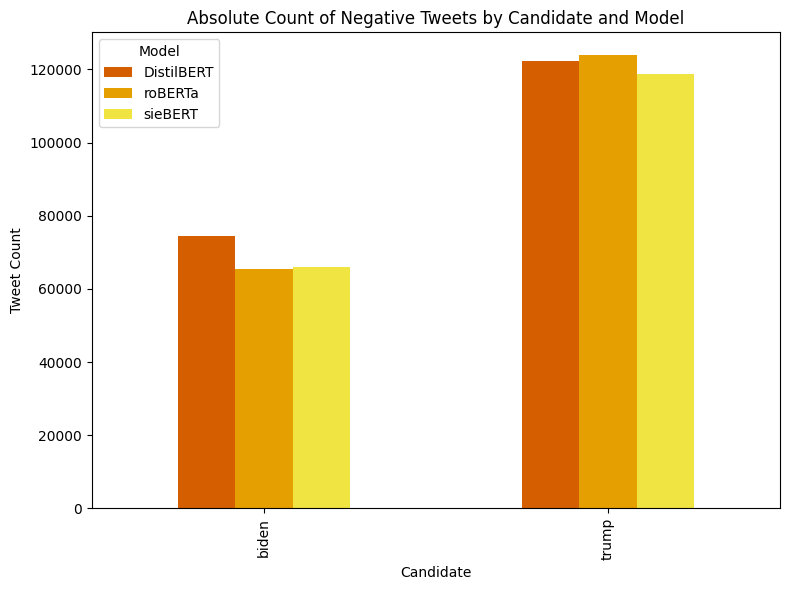

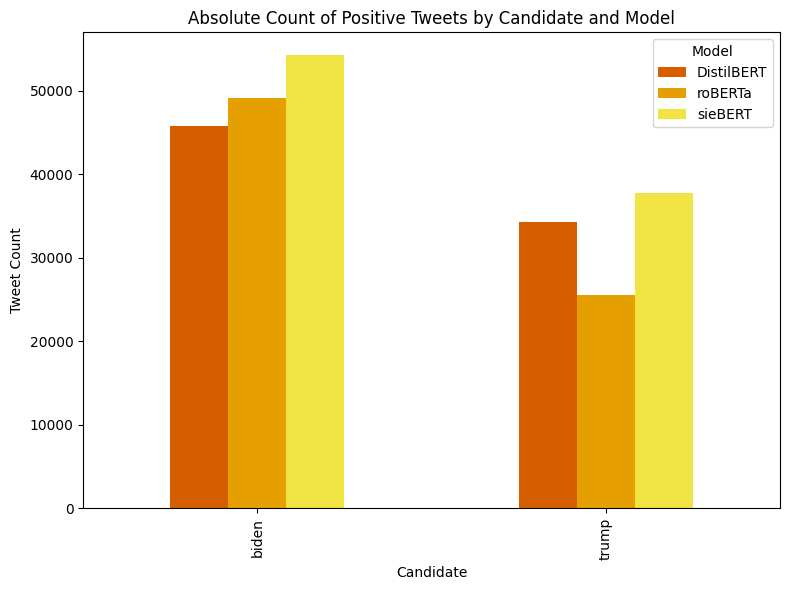

In [17]:
# Group the data: count of tweets by candidate, model, and sentiment.
aggregated = filtered_df.groupby(['candidate', 'model', 'sentiment'])\
                   .size().reset_index(name='count')

# Determine the unique sentiment categories
sentiments = aggregated['sentiment'].unique()

# Plot a unified chart for each sentiment category
for sentiment in sentiments:
    data_sentiment = aggregated[aggregated['sentiment'] == sentiment]
    # Pivot to get candidates as index and models as columns
    pivot = data_sentiment.pivot(index='candidate',
                                 columns='model',
                                 values='count').fillna(0)

    # Create a grouped bar chart for this sentiment
    ax = pivot.plot(kind='bar', figsize=(8, 6))
    ax.set_title(f"Absolute Count of {sentiment.capitalize()} Tweets by Candidate and Model")
    ax.set_xlabel("Candidate")
    ax.set_ylabel("Tweet Count")
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

#### Show normalized tweet counts by candidate and model

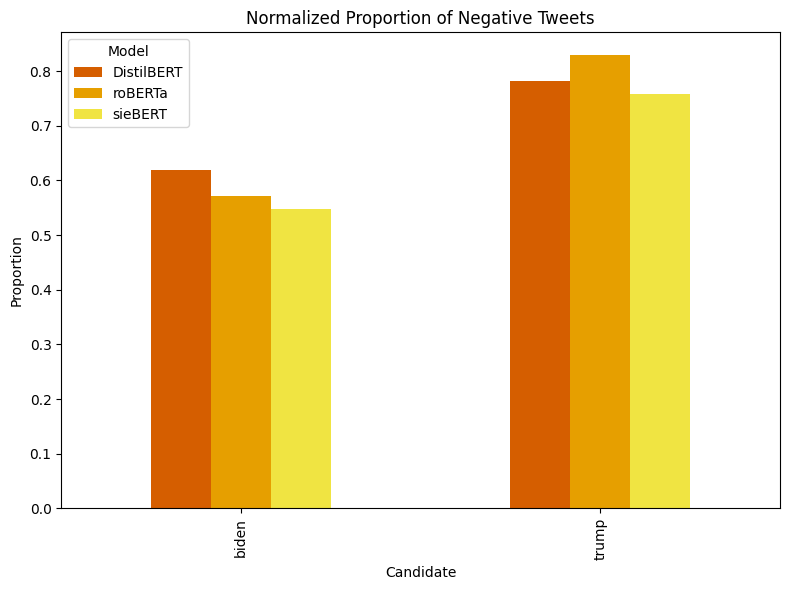

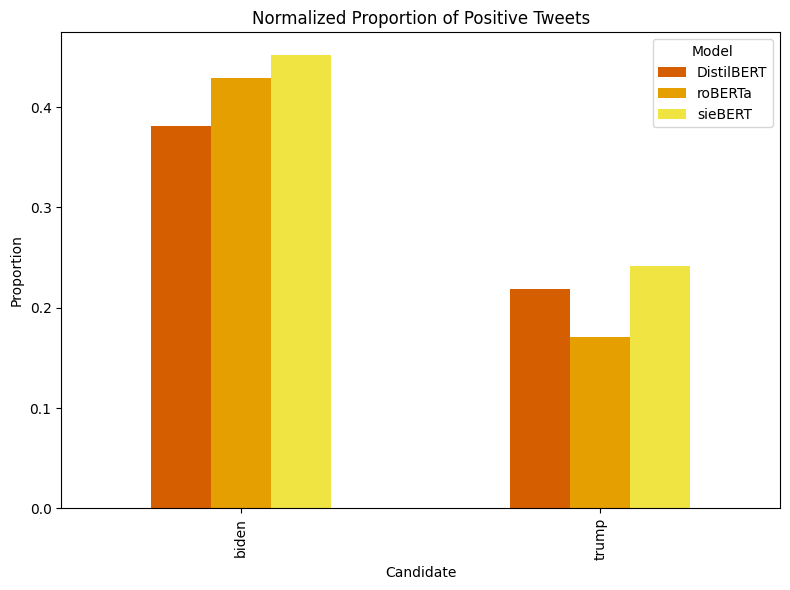

In [18]:
# Compute counts per candidate, model, and sentiment (as before)
aggregated = filtered_df.groupby(['candidate', 'model', 'sentiment'])\
                   .size()\
                   .reset_index(name='count')

# Compute total tweets per candidate and model
totals = aggregated.groupby(['candidate', 'model'])['count']\
                   .sum()\
                   .reset_index(name='total')

# Merge totals back into the aggregated DataFrame and compute proportions
aggregated = aggregated.merge(totals, on=['candidate', 'model'])
aggregated['proportion'] = aggregated['count'] / aggregated['total']

# Again, determine sentiment categories
sentiments = aggregated['sentiment'].unique()

# Plot normalized (proportional) counts for each sentiment category
for sentiment in sentiments:
    data_sentiment = aggregated[aggregated['sentiment'] == sentiment]
    pivot = data_sentiment.pivot(index='candidate',
                                 columns='model',
                                 values='proportion').fillna(0)

    ax = pivot.plot(kind='bar', figsize=(8, 6))
    ax.set_title(f"Normalized Proportion of {sentiment.capitalize()} Tweets")
    ax.set_xlabel("Candidate")
    ax.set_ylabel("Proportion")
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

#### Plot the normalized tweet counts by confidence levels in each model.

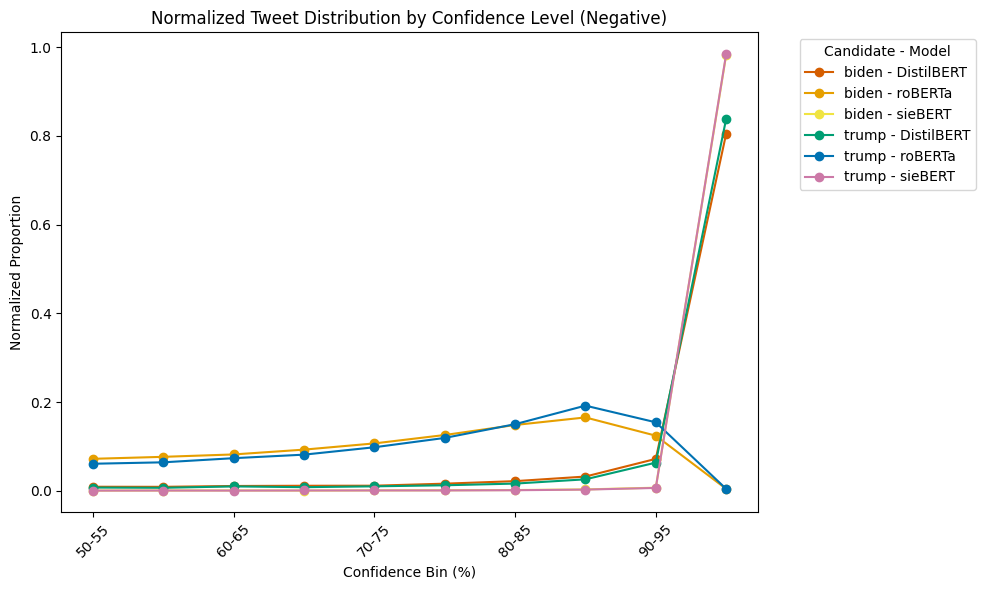

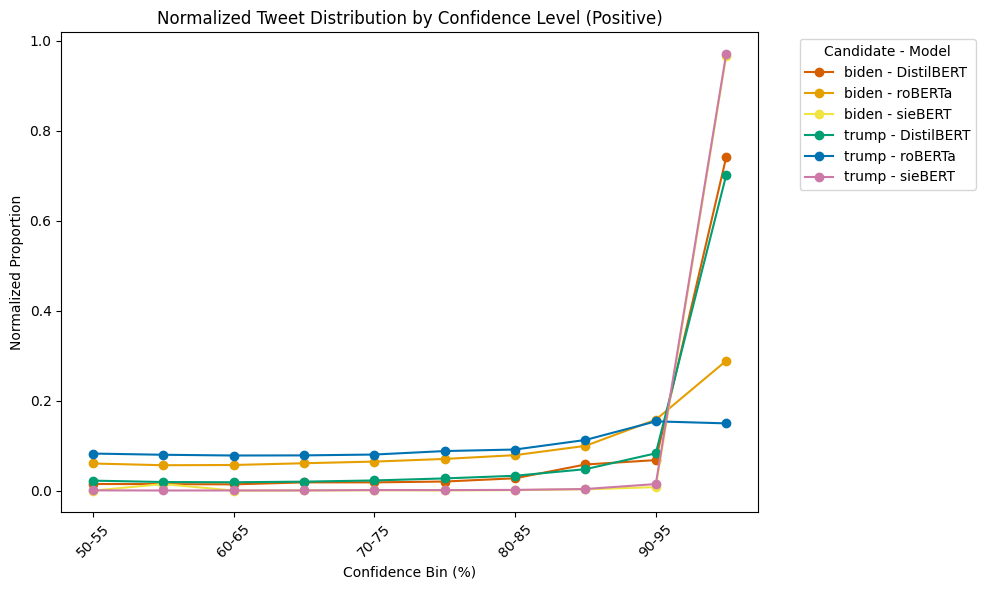

In [19]:
# Define confidence bins (from 50% to 100% in 5% increments)
bins = np.arange(0.50, 1.01, 0.05)
labels = [f"{int(bins[i]*100)}-{int(bins[i+1]*100)}" \
          for i in range(len(bins)-1)]

def plot_normalized_distribution_combined(df, bins, labels):
    # Filter for rows with clearly defined sentiments (positive or negative)
    df_filtered = df[df['sentiment'].isin(['positive', 'negative'])].copy()

    # Bin the sentiment_score values into the defined confidence ranges
    df_filtered['confidence_bin'] = pd.cut(
        df_filtered['sentiment_score'],
        bins=bins,
        labels=labels,
        right=False
    )

    # Group by candidate, model, sentiment, and confidence bin and count tweets
    grouped = (
        df_filtered
        .groupby(['candidate', 'model', 'sentiment', 'confidence_bin'],
                 observed=True)
        .size()
        .reset_index(name='count')
    )

    # Normalize: for each candidate-model-sentiment group,
    # compute the proportion per confidence bin
    grouped['total'] = grouped.groupby(['candidate',
                                        'model',
                                        'sentiment'])['count'].transform('sum')
    grouped['proportion'] = grouped['count'] / grouped['total']

    # Create a new column that combines candidate and
    # model for easier differentiation
    grouped['cand_model'] = grouped['candidate'] + " - " + grouped['model']

    # Set up a high contrast color palette for the lines
    high_contrast_palette = ["#D55E00",
                             "#E69F00",
                             "#F0E442",
                             "#009E73",
                             "#0072B2",
                             "#CC79A7"]
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=high_contrast_palette)

    # For each sentiment, pivot the data so that rows are confidence bins and
    # columns are cand_model, then plot the normalized proportions as a line chart.
    for sentiment in grouped['sentiment'].unique():
        subset = grouped[grouped['sentiment'] == sentiment]
        pivot = subset.pivot(index='confidence_bin',
                             columns='cand_model',
                             values='proportion')
        pivot = pivot.sort_index()  # Ensure the confidence bins are in order

        ax = pivot.plot(marker='o', figsize=(10, 6), kind='line')
        ax.set_title(f"Normalized Tweet Distribution by Confidence Level ({sentiment.capitalize()})")
        ax.set_xlabel("Confidence Bin (%)")
        ax.set_ylabel("Normalized Proportion")
        plt.xticks(rotation=45)
        plt.legend(title='Candidate - Model',
                   bbox_to_anchor=(1.05, 1),
                   loc='upper left')
        plt.tight_layout()
        plt.show()

plot_normalized_distribution_combined(all_df, bins, labels)

In both charts, we see how most lines remain relatively small and flat for the lower confidence bins, but then spike significantly at the highest bin (90–95% or 95–100%). This pattern suggests that:

**Models Frequently Assign “Very High” Confidence:**

Many tweets are placed into the top confidence bins, especially around 90–100%. These models appear to be “conservative” in the mid-range or if they jump directly to near-certain predictions for many tweets.

**Low-to-Mid Confidence Bins Have Fewer Tweets:**

Because these lines remain near zero in some middle bins (like 70–80%, 80–85%, etc.), it indicates that either the models rarely produce such mid-level confidence or those tweets are overshadowed by a large number of near-certain classifications.



### Additonal Meta-analyses

#### Intermodel Agreement Analysis

In [20]:
# Merge predictions on tweet_id between roBERTa and DistilBERT
merge_rd = df_roberta[['tweet_id', 'sentiment']].merge(
    df_distilbert[['tweet_id', 'sentiment']],
    on='tweet_id',
    suffixes=('_roberta', '_distilbert')
)

# Merge with sieBERT predictions (rename its sentiment column after merge)
merge_rds = merge_rd.merge(
    df_sieb[['tweet_id', 'sentiment']], on='tweet_id'
).rename(columns={'sentiment': 'sentiment_sieb'})

# Compute pairwise Cohen's Kappa
kappa_rd = cohen_kappa_score(merge_rds['sentiment_roberta'],
                             merge_rds['sentiment_distilbert'])
kappa_rs = cohen_kappa_score(merge_rds['sentiment_roberta'],
                             merge_rds['sentiment_sieb'])
kappa_ds = cohen_kappa_score(merge_rds['sentiment_distilbert'],
                             merge_rds['sentiment_sieb'])

print("Cohen's Kappa Scores (filtered to sentiment_score >= 80% and non-neutral):")
print("roBERTa vs DistilBERT:", kappa_rd)
print("roBERTa vs sieBERT:", kappa_rs)
print("DistilBERT vs sieBERT:", kappa_ds)

Cohen's Kappa Scores (filtered to sentiment_score >= 80% and non-neutral):
roBERTa vs DistilBERT: 0.5970651477898061
roBERTa vs sieBERT: 0.7741788100589333
DistilBERT vs sieBERT: 0.556934144422093


The Cohen's Kappa scores indicates substantial agreement between roBERTa vs sieBERT and moderate agreement with the other two pairs of models. It makes sense since sieBERT is based on the roBERTA model.

#### Correlation Analysis of Confidence Scores

In [21]:
# Merge the confidence scores from each model on tweet_id
merged_conf = df_roberta[['tweet_id', 'sentiment_score']].merge(
    df_distilbert[['tweet_id', 'sentiment_score']],
    on='tweet_id',
    suffixes=('_roberta', '_distilbert')
).merge(
    df_sieb[['tweet_id', 'sentiment_score']], on='tweet_id'
).rename(columns={'sentiment_score': 'sentiment_score_sieb'})

# Compute Pearson correlations
pearson_rd, _ = pearsonr(merged_conf['sentiment_score_roberta'],
                         merged_conf['sentiment_score_distilbert'])
pearson_rs, _ = pearsonr(merged_conf['sentiment_score_roberta'],
                         merged_conf['sentiment_score_sieb'])
pearson_ds, _ = pearsonr(merged_conf['sentiment_score_distilbert'],
                         merged_conf['sentiment_score_sieb'])

# Compute Spearman correlations
spearman_rd, _ = spearmanr(merged_conf['sentiment_score_roberta'],
                           merged_conf['sentiment_score_distilbert'])
spearman_rs, _ = spearmanr(merged_conf['sentiment_score_roberta'],
                           merged_conf['sentiment_score_sieb'])
spearman_ds, _ = spearmanr(merged_conf['sentiment_score_distilbert'],
                           merged_conf['sentiment_score_sieb'])

print("Pearson Correlations:")
print("roBERTa vs DistilBERT:", pearson_rd)
print("roBERTa vs sieBERT:", pearson_rs)
print("DistilBERT vs sieBERT:", pearson_ds)

print("\nSpearman Correlations:")
print("roBERTa vs DistilBERT:", spearman_rd)
print("roBERTa vs sieBERT:", spearman_rs)
print("DistilBERT vs sieBERT:", spearman_ds)



Pearson Correlations:
roBERTa vs DistilBERT: 0.10220287112253094
roBERTa vs sieBERT: 0.07548832524080112
DistilBERT vs sieBERT: 0.03886677426342901

Spearman Correlations:
roBERTa vs DistilBERT: 0.2528926839440374
roBERTa vs sieBERT: 0.30720482519449455
DistilBERT vs sieBERT: 0.313755086970226


**Low to Moderate Agreement in Confidence Scores:**
The very low Pearson correlation coefficients indicate almost no linear relationship between the models’ confidence scores, and Spearman coefficients suggest only a weak to moderate agreement in the ranking of tweets by confidence. This means that each model’s confidence score is largely independent of the others.

This is in stark contrast to the moderate to substantial agreement with the Kappa Scores. Kappa Scores are based on categorical agreement (i.e. simply "Positive" vs "Negative"), whereas the Pearson and Spearman corellations are based on the values of the confidence scores and so may not align well numerically as shown here.

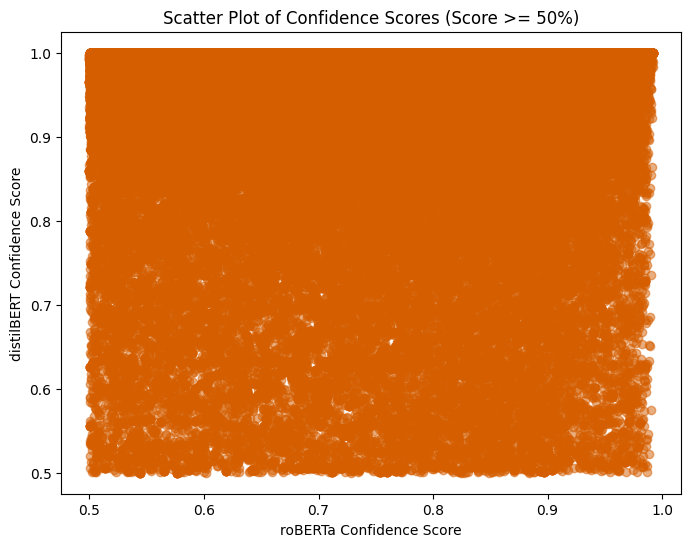

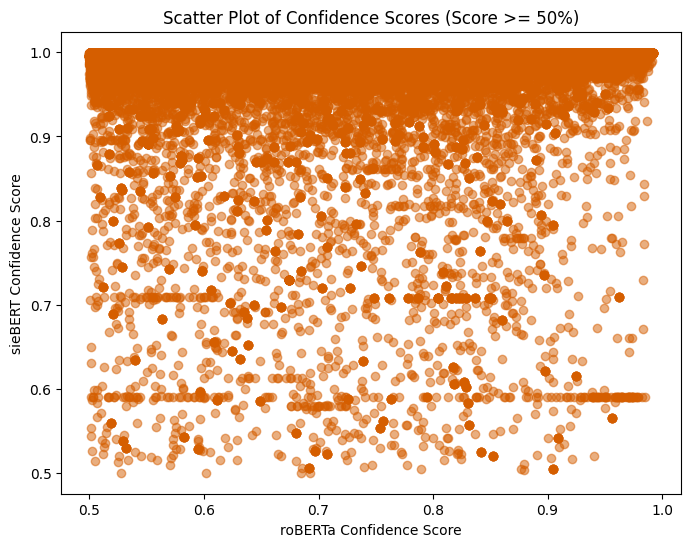

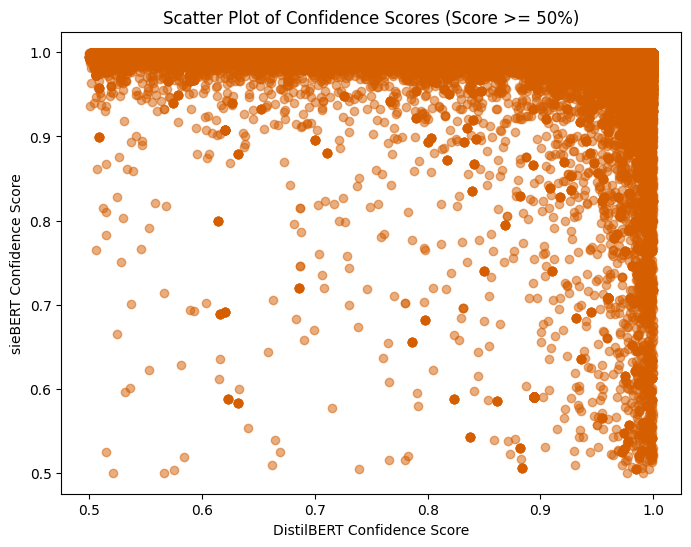

In [22]:
# Scatter plot for roBERTa vs DistilBERT
plt.figure(figsize=(8,6))
plt.scatter(merged_conf['sentiment_score_roberta'], merged_conf['sentiment_score_distilbert'], alpha=0.5)
plt.xlabel("roBERTa Confidence Score")
plt.ylabel("distilBERT Confidence Score")
plt.title("Scatter Plot of Confidence Scores (Score >= 50%)")
plt.show()

# Scatter plot for roBERTa vs sieBERT
plt.figure(figsize=(8,6))
plt.scatter(merged_conf['sentiment_score_roberta'], merged_conf['sentiment_score_sieb'], alpha=0.5)
plt.xlabel("roBERTa Confidence Score")
plt.ylabel("sieBERT Confidence Score")
plt.title("Scatter Plot of Confidence Scores (Score >= 50%)")
plt.show()

# Scatter plot for DistilBERT vs sieBERT
plt.figure(figsize=(8,6))
plt.scatter(merged_conf['sentiment_score_distilbert'], merged_conf['sentiment_score_sieb'], alpha=0.5)
plt.xlabel("DistilBERT Confidence Score")
plt.ylabel("sieBERT Confidence Score")
plt.title("Scatter Plot of Confidence Scores (Score >= 50%)")
plt.show()

#### **1. roBERTa vs. DistilBERT**:

**Dense clustering at DistilBERT = 1.0:**

Many points sit along the top edge, indicating that DistilBERT often assigns a confidence near 1.0 for tweets which roBERTa labels anywhere from 0.5 to 1.0.

**Wide horizontal “block” shape:**

Rather than a diagonal trend, we see more of a rectangular distribution. This suggests the two models’ raw scores do not scale linearly with each other.

**Interpretation:**

DistilBERT continues to show a tendency to output maximum confidence scores (1.0) frequently, while roBERTa is more varied from 0.5 up to 1.0. This leads to minimal linear correlation because roBERTa’s mid-to-high confidence can align with DistilBERT’s near-certain confidence in many tweets.

#### **2. roBERTa vs. sieBERT**

**Concentrations at sieBERT ≈ 1.0 and horizontal bands:**

We see a large chunk of points at the top (where sieBERT = 1.0) plus some “lines” where sieBERT appears to take particular values (like 0.6, 0.7, 0.8, 0.9). These lines likely stem from sieBERT rounding or discretizing confidence scores.

**roBERTa More Continuously Spread:**

roBERTa’s confidence from 0.5 to 1.0 is quite continuous, so you have a broad spread horizontally.

**Interpretation:**
The presence of discrete confidence levels in sieBERT vs. the continuous spread in roBERTa makes for a “striped” pattern. When sieBERT is 1.0, roBERTa can be anywhere from 0.5 to 1.0, reinforcing a weak linear correlation. However, it’s possible that tweets ranked relatively higher by sieBERT also tend to have higher roBERTa scores, which might show up as a modest Spearman correlation.

#### **3. DistilBERT vs. sieBERT**

**“L-Shape” with High Scores at the Top/Right:**

A strong cluster near (x ≈ 1.0, y ≈ 1.0) indicates many tweets for which both DistilBERT and sieBERT assign very high confidence. Nonetheless, there are also many points with x near 1.0 but y scattered between 0.5–1.0, and vice versa.

**Discrete Steps for sieBERT + DistilBERT Saturation:**

SieBERT appears to use discrete increments for confidence, and DistilBERT quite often saturates at 1.0. This can create the “L” boundary along the top (1.0 on the y-axis) and along the right side (1.0 on the x-axis).

**Interpretation:**

Even with neutrals removed, DistilBERT frequently assigns near-maximum confidence, while sieBERT is strong in the 0.9–1.0 range but also has distinct “stepped” confidence levels. Because of these different scoring behaviors, you get a broad scattering of points rather than a neat diagonal line.

#### Temporal Trends Sentiment Analysis

/usr/local/lib/python3.11/dist-packages/pandas/core/groupby/grouper.py:381: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  ax = Index(obj[key], name=key)


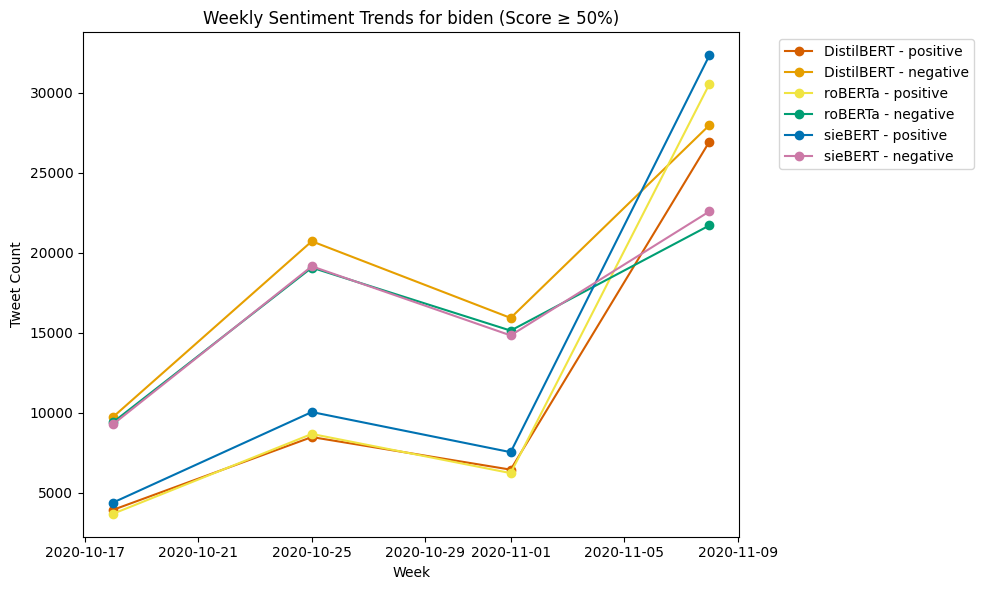

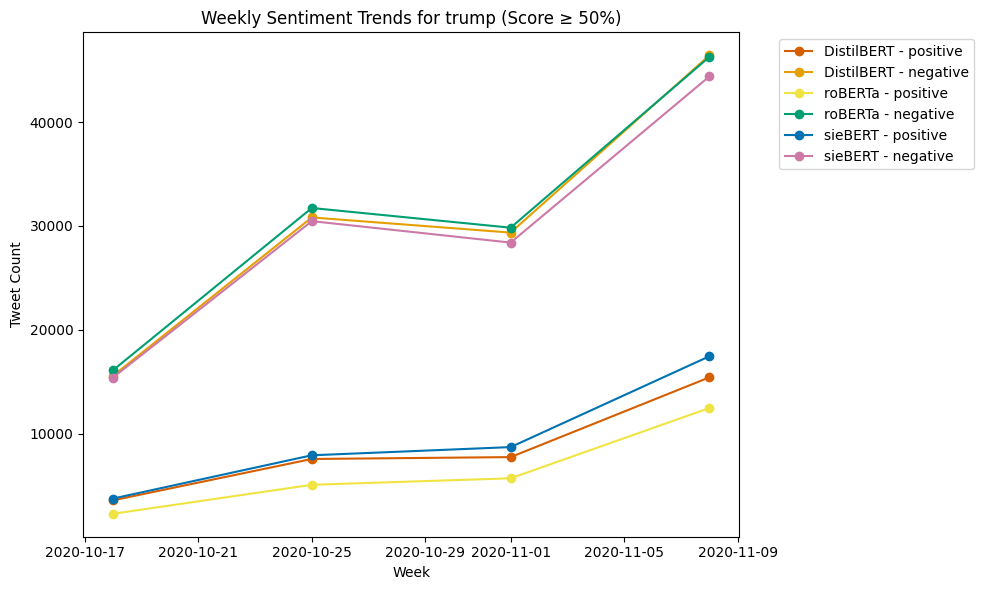

In [25]:
# Temporal Trends Sentiment Analysis
for df in [df_roberta, df_distilbert, df_sieb]:
    df.loc[:, 'created_at'] = pd.to_datetime(df['created_at']).infer_objects()

# Combine the filtered DataFrames
all_time_df = pd.concat([df_roberta, df_distilbert, df_sieb],
                        ignore_index=True)

# Group the data by week, candidate, model, and sentiment; count tweets
weekly_counts = all_time_df.groupby([pd.Grouper(key='created_at', freq='W'),
                                     'candidate', 'model', 'sentiment']) \
                           .size() \
                           .reset_index(name='count')

# Plot temporal trends for each candidate
# (each plot shows both sentiment types and all three models)
for candidate in weekly_counts['candidate'].unique():
    candidate_subset = weekly_counts[weekly_counts['candidate'] == candidate]

    plt.figure(figsize=(10,6))

    # Loop through each model and sentiment combination
    for model in candidate_subset['model'].unique():
        for sentiment in ['positive', 'negative']:
            subset = candidate_subset[(candidate_subset['model'] == model) & \
                                      (candidate_subset['sentiment'] == sentiment)]
            if not subset.empty:
                plt.plot(subset['created_at'], subset['count'], marker='o',
                         label=f"{model} - {sentiment}")

    plt.title(f"Weekly Sentiment Trends for {candidate} (Score ≥ 50%)")
    plt.xlabel("Week")
    plt.ylabel("Tweet Count")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

As is expected we see higher tweet counts as time approaches election day. However in Trump's case his negative tweets increase a lot more while Biden's positive tweets also increase.